In [1]:
import numpy as np
import sys

import itertools

import matplotlib.pyplot as plt

In [2]:
sys.path.append("../utils/")

In [3]:
import plot_utils as pu
import graph_transformation as gt

In [4]:
X = np.load("../../data/simulation/1000_35_like_true/amp_gr.npy")
Y = np.load("../../data/simulation/1000_35_like_true/populations_gr.npy")

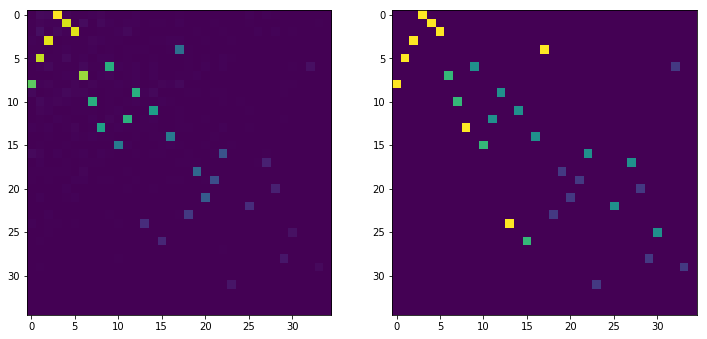

In [19]:
pu.plot_grs(X[0], Y[0], s = 12)

In [20]:
gr, gr_y = X[0], Y[0]

In [21]:
def gr_to_pairs(gr):
    N = gr.shape[0]
    pairs = [x for x in itertools.product(range(N), range(N))]
    pairs_counts = {}
    
    for p in pairs:
        if gr[p[0], p[1]] > 0: pairs_counts[p] = gr[p[0], p[1]].astype(int)
    
    
    p_to_n = dict(zip(pairs_counts.keys(), np.arange(len(pairs)).astype(int)))
    n_to_p = dict(zip(np.arange(len(pairs)).astype(int), pairs_counts.keys()))
    
    return pairs_counts, p_to_n, n_to_p, N

In [22]:
def pairs_to_sparse_gr(p_to_n):
    N = len(p_to_n)
    first = dict(zip(range(N), [[] for i in range(N)] ))
    second = dict(zip(range(N), [[] for i in range(N)]))
    
    for p in p_to_n.keys():
        first[p[0]].append(p)
        second[p[1]].append(p)
    
    gr = np.zeros((N, N))
    
    for p in p_to_n.keys():
        for p2 in first[p[1]]:
            gr[p_to_n[p]][p_to_n[p2]] = 1
    
    return gr, first, second

In [23]:
pairs, p_to_n, n_to_p, N = gr_to_pairs(gr)

In [10]:
d = {(0,1) : 0, (1,0) : 1, (1,2) : 2}

In [24]:
gr_n = pairs_to_sparse_gr(p_to_n)

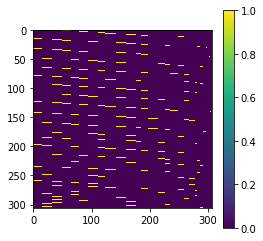

In [25]:
pu.plot_gr(gr_n[0], s  =4)

In [26]:
def make_vertexes_embs(gr, p_to_n):
    embs = np.zeros((len(p_to_n), 5))
    
    for i, p in enumerate(p_to_n.keys()):
        embs[i, 0] = gr[p[0], p[1]]
        embs[i, 1] = embs[i, 0] / gr[p[0]].sum()
        embs[i, 2] = embs[i, 0] / gr[:, p[1]].sum()
        
        embs[i, 3] = embs[i, 0] / max(1, gr[:, p[0]].sum())
        embs[i, 4] = embs[i, 0] / max(1, gr[p[1]].sum())
    return embs
        

In [27]:
def make_y(gr_y, p_to_n):
    y = np.zeros(len(p_to_n)).astype(int)
    
    for i, p in enumerate(p_to_n.keys()):
        y[i] = (gr_y[p[0], p[1]] > 0).astype(int)
        
    return y

In [36]:
def process_graph(grx, gry):
    pairs, p_to_n, n_to_p, N = gr_to_pairs(grx)
    
    adj = pairs_to_sparse_gr(p_to_n)[0]
    
    vertex_embs = make_vertexes_embs(grx, p_to_n)
    answ = make_y(gry, p_to_n) 
    
    return adj, vertex_embs, answ

In [45]:
process_graph(X[0], Y[0])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[5.00000000e+00, 2.22222222e-02, 2.28310502e-02, 2.95857988e-02,
         2.32558140e-02],
        [4.00000000e+00, 1.77777778e-02, 1.85185185e-02, 2.36686391e-02,
         1.84331797e-02],
        [1.95000000e+02, 8.66666667e-01, 8.98617512e-01, 1.15384615e+00,
         9.37500000e-01],
        ...,
        [1.00000000e+00, 1.66666667e-01, 4.56621005e-03, 6.66666667e-02,
         4.65116279e-03],
        [5.00000000e+00, 8.33333333e-01, 8.33333333e-01, 3.33333333e-01,
         5.00000000e+00],
        [1.10000000e+01, 1.00000000e+00, 7.85714286e-01, 1.10000000e+01,
         3.05555556e-01]]),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [15]:
from tqdm import tqdm_notebook

In [16]:
X.shape

(1000, 35, 35)

In [27]:
NEW_X = []
NEW_Y = []
adj = []


for x, y in tqdm_notebook(zip(X, Y)):
    pairs, p_to_n, n_to_p, N = gr_to_pairs(x)
    gr = pairs_to_sparse_gr(p_to_n)
    
    
    new_x = make_vertexes_embs(x, p_to_n)
    new_y = make_y(y, p_to_n) 
    
    adj.append(gr)
    NEW_X.append(new_x)
    NEW_Y.append(new_y)

A Jupyter Widget

In [28]:
embs = np.array(NEW_X)
adjs = np.array(adj)
target = np.array(NEW_Y)

In [34]:
np.save("../../data/gnn_prepared/embs", embs)
np.save("../../data/gnn_prepared/adjs", adjs)
np.save("../../data/gnn_prepared/target", target)

In [31]:
train_x = np.vstack(NEW_X[:800])[:, 1:]
train_y = np.hstack(NEW_Y[:800])

val_x = np.vstack(NEW_X[800:])[:, 1:]
val_y = np.hstack(NEW_Y[800:])